In [28]:
import ns_model
import warnings
import importlib
import numpy as np
import pandas as pd
import astropy.units as u
from matplotlib import ticker
import matplotlib.pyplot as plt
from scipy.optimize import root
import matplotlib.gridspec as gridspec
warnings.filterwarnings('ignore')
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [2]:
importlib.reload(ns_model)
df1 = pd.read_csv('pulsar_data\\QHC18.csv')
df2 = pd.read_csv('pulsar_data\\free_neutron.csv')
df3 = pd.read_csv('pulsar_data\\glitch_data.csv')
df4 = pd.read_csv('pulsar_data\\pulsar_glitch_profile.csv')
df5 = pd.read_csv('pulsar_data\\pulsar_glitch_dist.csv')
ns_inputs = {'central_density': 3.5, 'proton_frac': 0.05}
nsm = ns_model.NeutronStar(df1, df2, df3, df4, df5, ns_inputs, verbose=False)

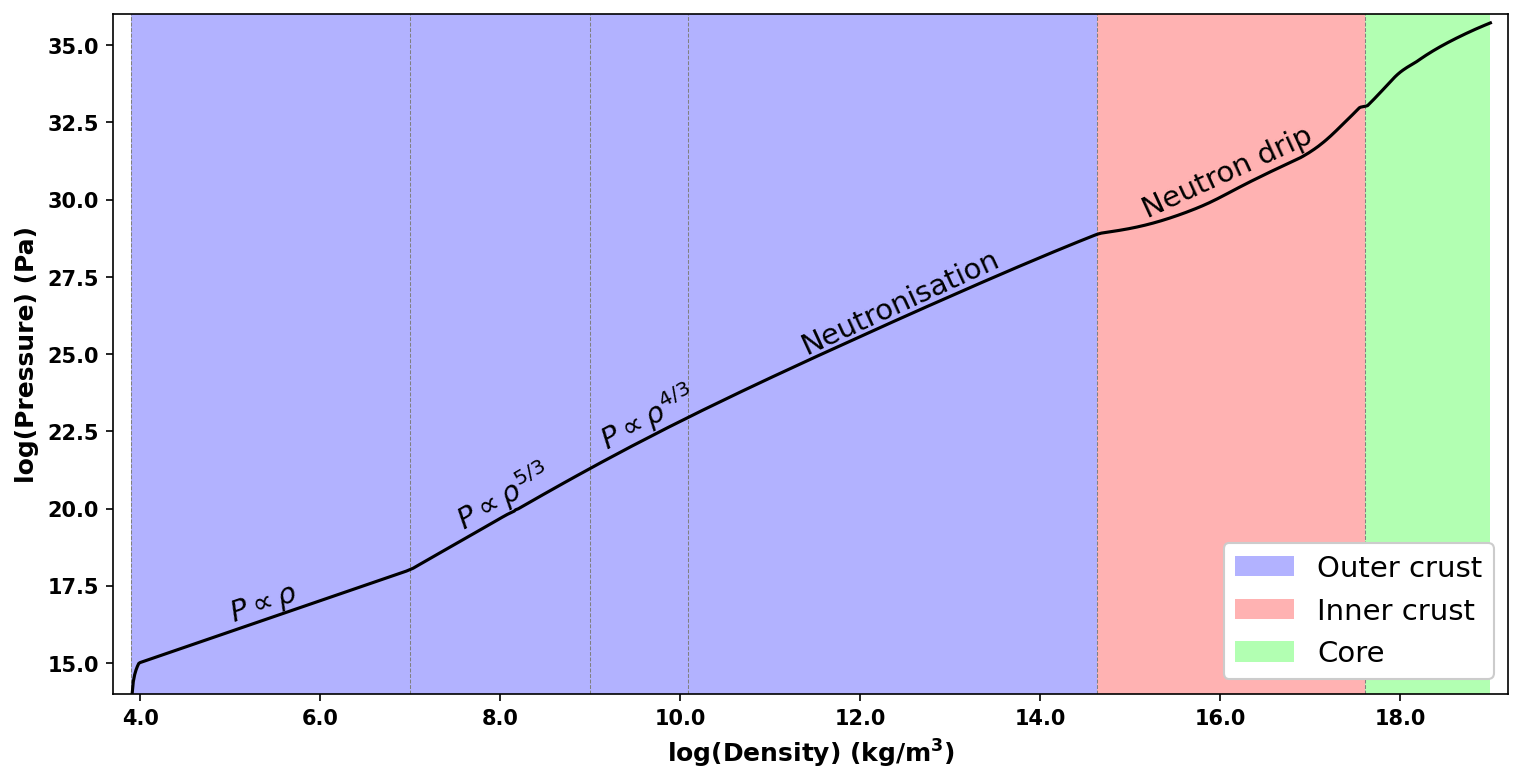

In [123]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=150)
dl = np.log10(np.array([7.9e3, 1e7, 1e9, 1.2e10, 4.3e14, 4e17]))
dens_r = np.geomspace(7e3, 1e19, 1000)
for rho_i in dl:
    ax.axvline(rho_i, c='gray', linestyle='--', lw=0.5)
ax.plot(np.log10(dens_r), np.log10(nsm.EoS_f[0](dens_r)), 'k-')
ax.set_xlabel(r'log(Density) (kg/$\mathbf{m^{3}}$)', fontsize=12, weight='bold')
ax.set_ylabel('log(Pressure) (Pa)', fontsize=12, weight='bold')
ax.set_ylim([14, 36])
ax.set_xlim([3.7, 19.2])

ax.fill_betweenx(y=[14, 36], x1=dl[0], x2=dl[4], fc='blue', alpha=0.3, label='Outer crust')
ax.fill_betweenx(y=[14, 36], x1=dl[4], x2=dl[5], fc='red', alpha=0.3, label='Inner crust')
ax.fill_betweenx(y=[14, 36], x1=dl[5], x2=np.log10(dens_r[-1]), fc='lime', alpha=0.3, label='Core')
ax.legend(loc=4, fontsize=14, framealpha=1)

def generate(ir, il, i, label):
    x, y = np.log10(dens_r), np.log10(nsm.EoS_f[0](dens_r))
    dy = y[il] - y[ir]
    dx = x[il] - x[ir]
    angle = np.rad2deg(np.arctan2(dy, dx))
    ax.text(x[i], y[i], label, va='bottom', c='black', fontsize=14,
             transform_rotates_text=True, rotation=angle, rotation_mode='anchor')

generate(70, 90, 80, r'$P \propto \rho$')
generate(240, 270, 250, r'$P \propto \rho^{5/3}$')
generate(350, 360, 355, r'$P \propto \rho^{4/3}$')
generate(490, 510, 500, 'Neutronisation')
generate(490, 510, 750, 'Neutron drip')

ax.set_yticklabels(ax.get_yticks(), weight='bold')
ax.set_xticklabels(ax.get_xticks(), weight='bold')

In [4]:
moi_, strut_, funcs = [], [], []
dens0_ = np.arange(2,12, 0.1)
for c_d in dens0_:
    ns_inputs = {'central_density': c_d, 'proton_frac': 0.05}
    nsm = ns_model.NeutronStar(df1, df2, df3, df4, df5, ns_inputs, verbose=False)
    moi_.append(list(nsm.moi_.values()))
    strut_.append(list(nsm.profile.values()))
    funcs.append([nsm.density, nsm.enc_mass, nsm.dens_])
moi_arr = np.array(moi_)
strut_arr = np.array(strut_)

In [5]:
Ing, Ic, Il, It = moi_arr.T
r, crust, core, mass = strut_arr.T
d_f, em_f, ds_f = np.array(funcs).T

Text(0, 0.5, 'Density [$\\mathrm{kg/m^3}$]')

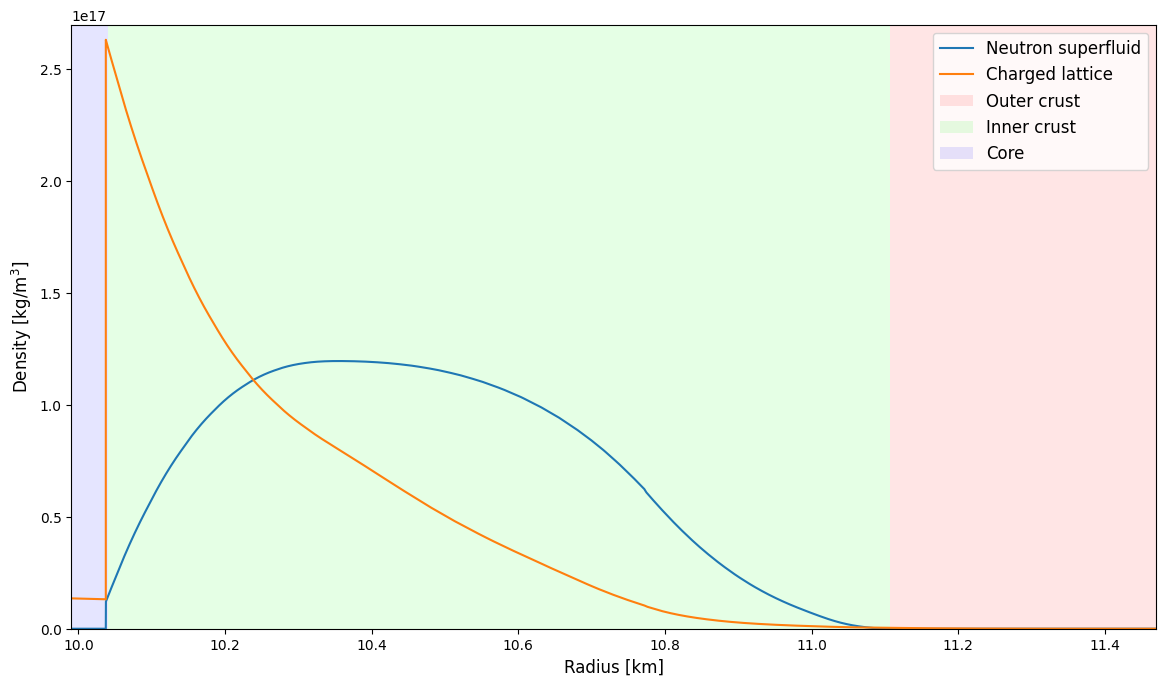

In [6]:
fig, ax = plt.subplots(figsize=(14, 8), dpi=100)
i = 20 # 1.4 solar mass
dd = ds_f[i]

r_ = np.linspace(core[i]-50, r[i], 100000)/1000
ax.plot(r_, dd['n_gas'](r_*1000), label='Neutron superfluid')
ax.plot(r_, dd['charged'](r_*1000), label='Charged lattice')
ax.set_xlim(r_.min(), r_.max())
ax.set_ylim(0, 2.7e17)

ax.fill_betweenx(y=[0, 2.7e17], x1=crust[i]/1000, x2=r[i]/1000, fc='red', alpha=0.1, label='Outer crust')
ax.fill_betweenx(y=[0, 2.7e17], x1=(core[i])/1000, x2=crust[i]/1000, fc='lime', alpha=0.1, label='Inner crust')
ax.fill_betweenx(y=[0, 2.7e17], x1=(core[i]-50)/1000, x2=(core[i])/1000, fc='blue', alpha=0.1, label='Core')

ax.legend(fontsize=12)
ax.set_xlabel('Radius [km]', fontsize=12)
ax.set_ylabel('Density [$\mathrm{kg/m^3}$]', fontsize=12)

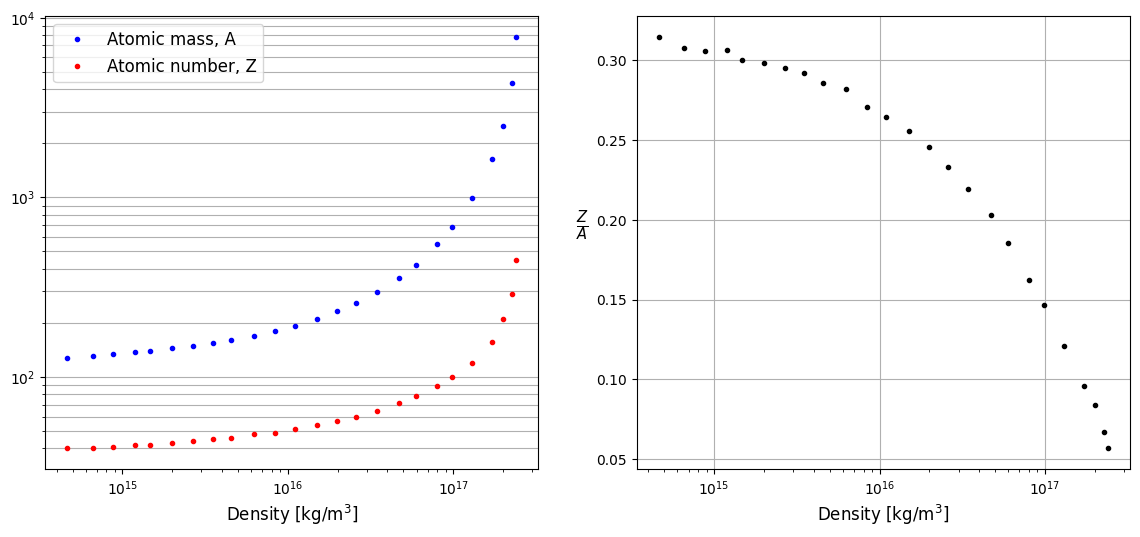

In [7]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6), dpi=100)
ax1.plot(df2.density*1e3, df2.A, 'b.', label='Atomic mass, A')
ax1.plot(df2.density*1e3, df2.Z, 'r.', label='Atomic number, Z')
ax2.plot(df2.density*1e3, df2.Z/df2.A, 'k.')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')

ax1.set_xlabel('Density [$\mathrm{kg/m^3}$]', fontsize=12)
ax2.set_xlabel('Density [$\mathrm{kg/m^3}$]', fontsize=12)
ax2.set_ylabel(r'$\frac{Z}{A}$', fontsize=15, rotation=0, labelpad=10)
ax1.legend(fontsize=12)
ax1.grid(which='both', axis='y')
ax2.grid()

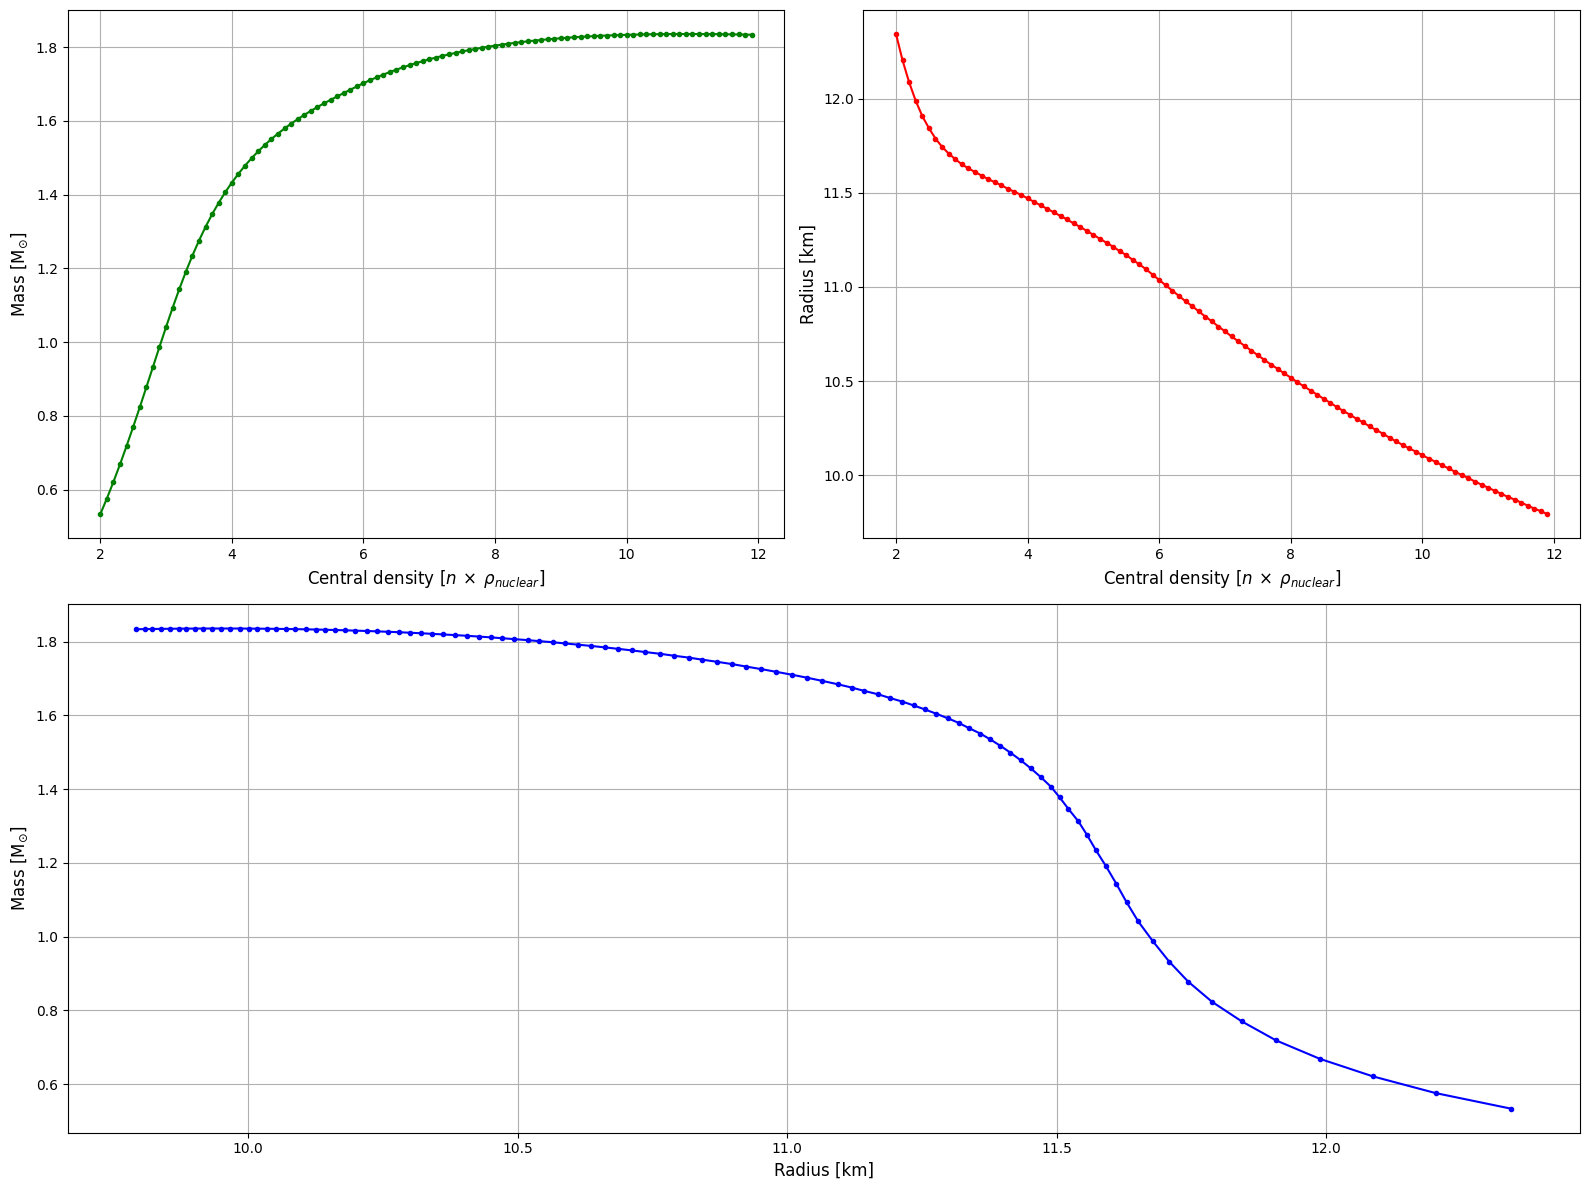

In [8]:
fig = plt.figure(tight_layout=True,  figsize=(16, 12), dpi=100)
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[1, :])
ax.plot(r/1000, mass, 'b.-')
ax.set_xlabel('Radius [km]', fontsize=12)
ax.set_ylabel(r'Mass $\mathrm{[M_{\odot}]}$', fontsize=12)
ax.grid()

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(dens0_, mass, 'g.-')
ax1.set_xlabel(r'Central density [$n\:\times\:\rho_{nuclear} $]', fontsize=12)
ax1.set_ylabel(r'Mass $\mathrm{[M_{\odot}]}$', fontsize=12)
ax1.grid()

ax2 = fig.add_subplot(gs[0,1])
ax2.plot(dens0_, r/1000, 'r.-')
ax2.set_ylabel('Radius [km]', fontsize=12)
ax2.set_xlabel(r'Central density [$n\:\times\:\rho_{nuclear} $]', fontsize=12)
ax2.grid()

In [ ]:
@ticker.FuncFormatter
def major_formatter(x, pos):
    return f'{x:.2f}'

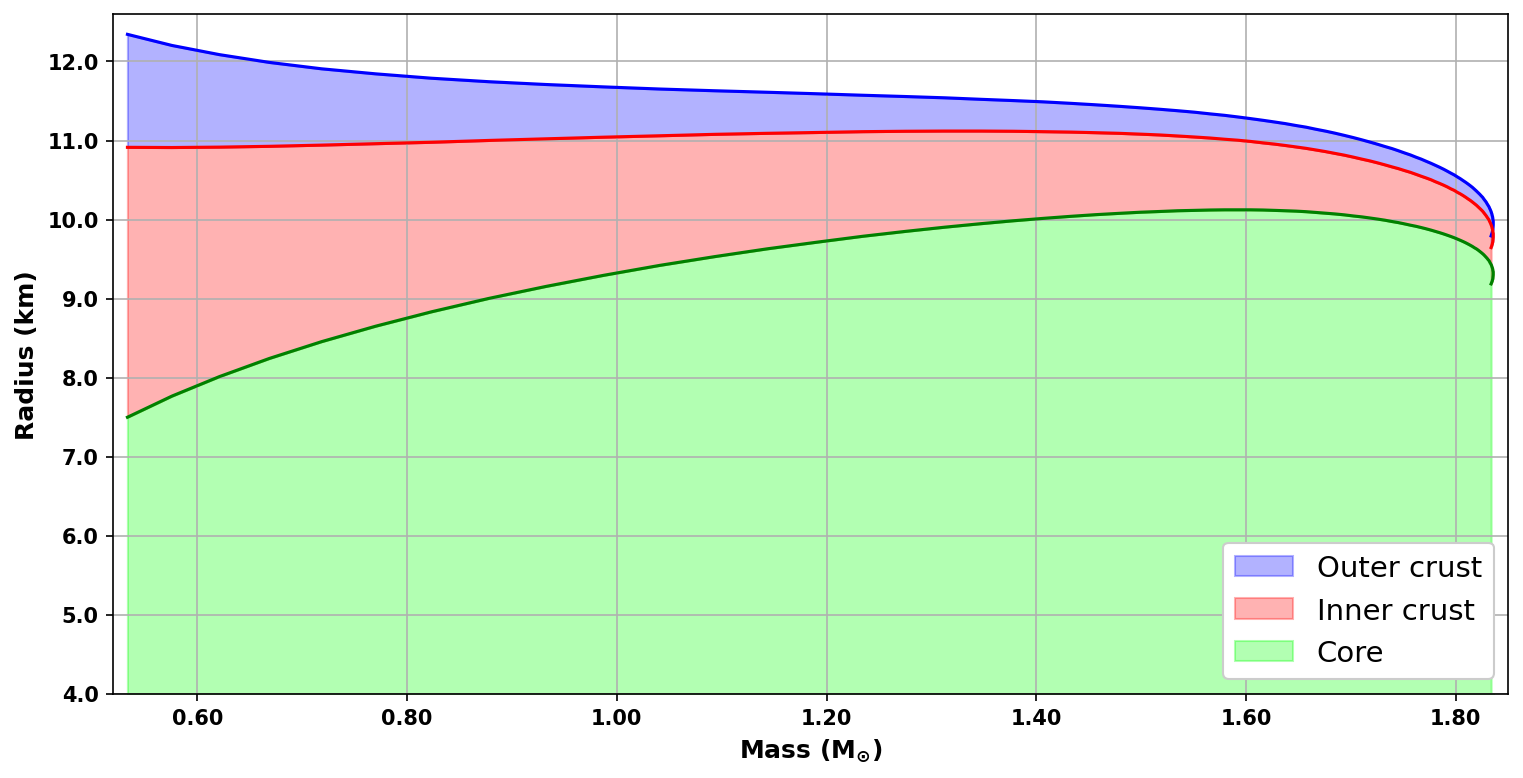

In [132]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=150)
ax.plot(np.round(mass, 4), r/1000, 'b-')
ax.plot(np.round(mass, 4), crust/1000, 'r-')
ax.plot(np.round(mass, 4), core/1000, 'g-')
ax.set_xlabel(r'Mass $\mathbf{(M_{\odot})}$', fontsize=12, weight='bold')
ax.set_ylabel('Radius (km)', fontsize=12, weight='bold')

ax.fill_between(mass, r/1000, crust/1000, color='blue', alpha=0.3, label='Outer crust')
ax.fill_between(mass, crust/1000, core/1000, color='red', alpha=0.3, label='Inner crust')
ax.fill_between(mass, core/1000, 4, color='lime', alpha=0.3, label='Core')
ax.legend(fontsize=14, framealpha=1, loc=4)
ax.set_ylim([4, 12.6])
ax.set_xlim([0.52, 1.85])
ax.grid()
ax.set_yticklabels(ax.get_yticks(), weight='bold')
ax.set_xticklabels(ax.get_xticks(), weight='bold')
ax.xaxis.set_major_formatter(major_formatter)

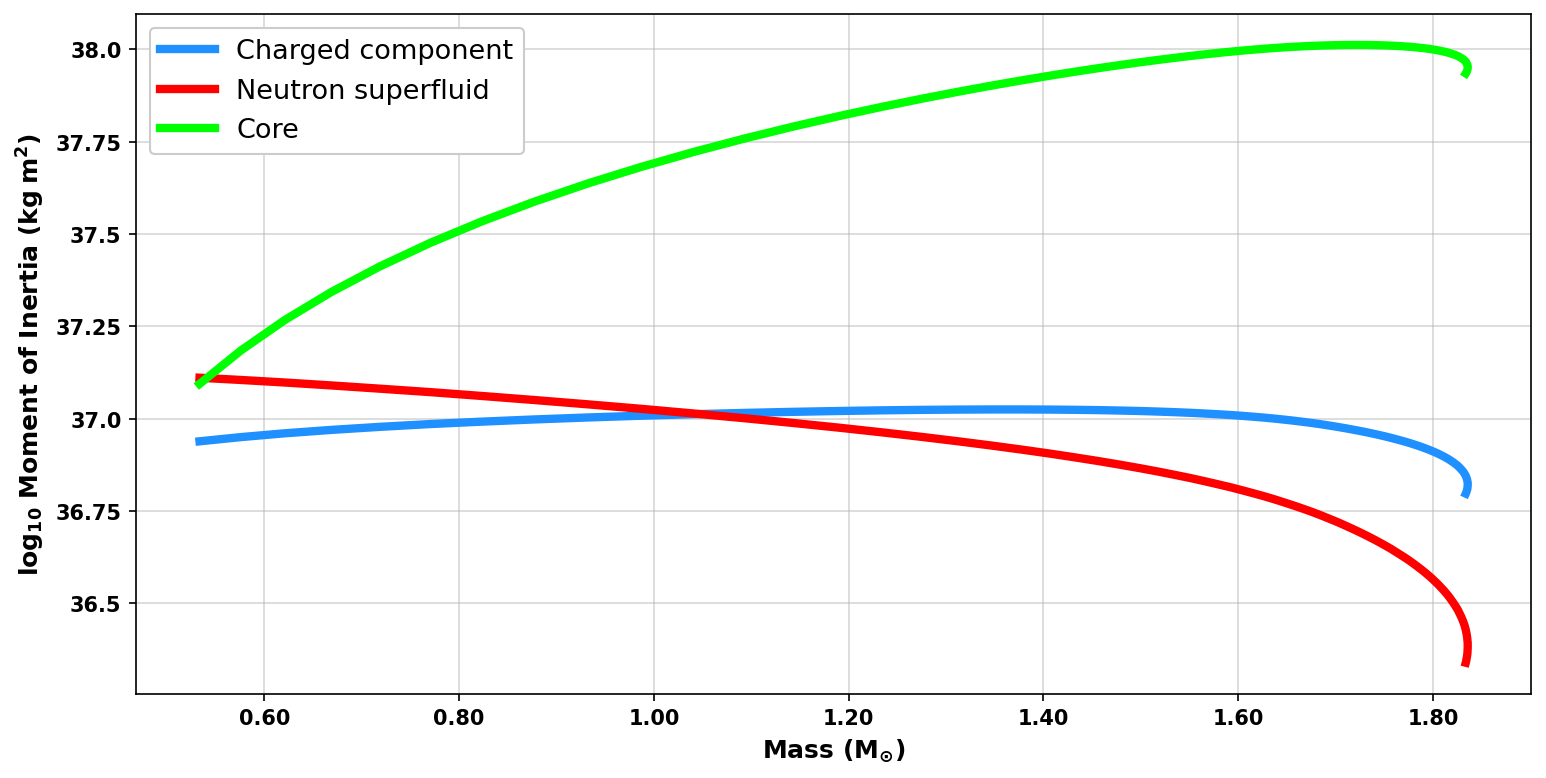

In [157]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=150)
conv = u.Msun.to(u.kg)*1e6
ax.plot(mass, np.log10(Ic), 'b-', c='dodgerblue',lw=4, label='Charged component')
ax.plot(mass, np.log10(Ing),  'r-', lw=4, label='Neutron superfluid')
ax.plot(mass, np.log10(Il), 'g-', c='lime', lw=4, label='Core')
ax.set_xlabel(r'Mass $\mathbf{(M_{\odot})}$', fontsize=12,  weight='bold')
ax.set_ylabel(r'log$\mathbf{_{10}}$ Moment of Inertia $\mathbf{(kg \:m^2)}$', fontsize=12,  weight='bold')
ax.legend(fontsize=13, framealpha=1)
ax.grid(which='both', alpha=0.5)
ax.set_yticklabels(ax.get_yticks(), weight='bold')
ax.set_xticklabels(ax.get_xticks(), weight='bold')
ax.xaxis.set_major_formatter(major_formatter)